<a href="https://colab.research.google.com/github/anoldKupara/Machine-Learning-Course/blob/main/Swedish_Motor_Insurance_Simple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/SwedishMotorInsurance.csv')

In [ ]:
df.head()

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment
0,1,1,1,1,455.13,108,392491
1,1,1,1,2,69.17,19,46221
2,1,1,1,3,72.88,13,15694
3,1,1,1,4,1292.39,124,422201
4,1,1,1,5,191.01,40,119373


In [ ]:
df = df[df['Payment']!= 0]
df = df[df['Payment'] <=1000000]

In [ ]:
#Creation of new features

df['payment_per_insured'] = df['Payment']/df['Insured']
df['payment_per_claims'] = df['Payment']/df['Claims']
df['payment_per_insured_per_claims'] = df['Payment']/(df['Claims']*df['Insured'])
df['insured_per_claims'] = df['Insured']/df['Claims']
df['Payment'] = np.log1p(df['Payment'])

In [ ]:
#Correlation Matrix

df.corr()

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment,payment_per_insured,payment_per_claims,payment_per_insured_per_claims,insured_per_claims
Kilometres,1.000000,-0.056942,0.023031,0.055079,-0.178110,-0.098518,-0.164910,0.136550,0.039425,0.119145,-0.233829
Zone,-0.056942,1.000000,0.046076,0.062224,-0.004138,-0.102327,-0.172040,-0.010793,0.057152,0.106675,0.205408
Bonus,0.023031,0.046076,1.000000,-0.004695,0.321803,0.126637,0.190572,-0.239841,0.022509,-0.129375,0.443198
Make,0.055079,0.062224,-0.004695,1.000000,0.083255,0.119291,0.014710,0.024667,0.024393,0.040612,-0.017524
Insured,-0.178110,-0.004138,0.321803,0.083255,1.000000,0.836281,0.605310,-0.139125,-0.018223,-0.118660,0.228662
Claims,-0.098518,-0.102327,0.126637,0.119291,0.836281,1.000000,0.709060,-0.068511,-0.034963,-0.132207,-0.011641
Payment,-0.164910,-0.172040,0.190572,0.014710,0.605310,0.709060,1.000000,0.117897,0.306105,-0.080893,-0.037952
payment_per_insured,0.136550,-0.010793,-0.239841,0.024667,-0.139125,-0.068511,0.117897,1.000000,0.605666,0.870388,-0.314849
payment_per_claims,0.039425,0.057152,0.022509,0.024393,-0.018223,-0.034963,0.306105,0.605666,1.000000,0.545652,0.058063
payment_per_insured_per_claims,0.119145,0.106675,-0.129375,0.040612,-0.118660,-0.132207,-0.080893,0.870388,0.545652,1.000000,-0.138616


In [ ]:
from sklearn.metrics import r2_score

train = df[['Claims','Insured','Payment']]
x=train.drop('Payment',axis =1)
y=train['Payment']
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size = 0.2 , random_state = 42)

from sklearn.ensemble import RandomForestRegressor

param_grid = {
                 'n_estimators': range(10,110,10),
                 'max_depth': range(2,10)
             }
from sklearn.model_selection import GridSearchCV
clf = RandomForestRegressor()
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
print('train R2:',r2_score(y_train , grid_clf.predict(x_train)),'test R2:',r2_score(y_test, grid_clf.predict(x_test)))

train R2: 0.8325973290123317 test R2: 0.8260170051749135


In [ ]:
df['PLS'] = grid_clf.predict(df[['Claims','Insured']])

In [ ]:
df.head()

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment,payment_per_insured,payment_per_claims,payment_per_insured_per_claims,insured_per_claims,PLS
0,1,1,1,1,455.13,108,12.880271,862.371191,3634.175926,7.984918,4.214167,13.153345
1,1,1,1,2,69.17,19,10.741211,668.223218,2432.684211,35.169643,3.640526,11.321424
2,1,1,1,3,72.88,13,9.661097,215.340285,1207.230769,16.564637,5.606154,10.964655
3,1,1,1,4,1292.39,124,12.953239,326.682348,3404.846774,2.634535,10.422500,13.306355
4,1,1,1,5,191.01,40,11.690017,624.956809,2984.325000,15.623920,4.775250,12.004015


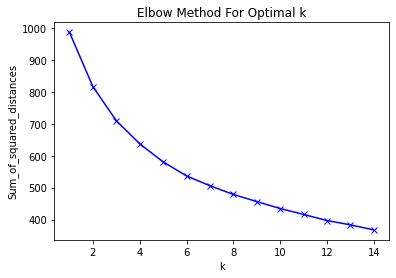

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

mms = MinMaxScaler()
mms.fit(df)
data_transformed = mms.transform(df)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
knn = KMeans(n_clusters=5).fit(data_transformed)
df['cluster'] = knn.predict(data_transformed)
cluster_means = df.groupby('cluster')['Payment'].mean().reset_index()
cluster_means.columns = ['cluster','mean']
df = df.merge(cluster_means , on = 'cluster' )
df.drop('cluster' , axis = 1 , inplace = True)

In [ ]:
df.head()

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment,payment_per_insured,payment_per_claims,payment_per_insured_per_claims,insured_per_claims,PLS,mean
0,1,1,1,1,455.13,108,12.880271,862.371191,3634.175926,7.984918,4.214167,13.153345,10.966881
1,1,1,1,2,69.17,19,10.741211,668.223218,2432.684211,35.169643,3.640526,11.321424,10.966881
2,1,1,1,3,72.88,13,9.661097,215.340285,1207.230769,16.564637,5.606154,10.964655,10.966881
3,1,1,1,4,1292.39,124,12.953239,326.682348,3404.846774,2.634535,10.422500,13.306355,10.966881
4,1,1,1,5,191.01,40,11.690017,624.956809,2984.325000,15.623920,4.775250,12.004015,10.966881


In [ ]:
#The average of the Payment from the previous regression and the cluster mean is also used a feature

df['avg'] = (df['PLS']+df['mean'])/2

In [ ]:
from sklearn.linear_model import LinearRegression
x=df.drop(['Payment','PLS','mean'],axis =1)
y=df['Payment']

x_train , x_test , y_train , y_test = train_test_split(x,y, test_size = 0.2 , random_state = 42)
sc = StandardScaler()
scaled_x_train = sc.fit_transform(x_train)
scaled_x_test = sc.transform(x_test)

model = LinearRegression().fit(scaled_x_train , y_train)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print('training RMSE:',np.sqrt(mse(np.expm1(y_train) , np.expm1(model.predict(scaled_x_train)))))
print('test RMSE:',np.sqrt(mse(np.expm1(y_test), np.expm1(model.predict(scaled_x_test)))))

training RMSE: 85687.27516332551
test RMSE: 98601.77803207564


In [ ]:
print(r2_score(y_test,model.predict(scaled_x_test)))

0.9077677935390048


In [ ]:
print(r2_score(y_train,model.predict(scaled_x_train)))

0.9166553947772564


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
